In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/real-or-fake-fake-jobposting-prediction/fake_job_postings.csv


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import warnings
warnings.simplefilter (action = 'ignore') # Hata göstermemesi için import ettik

In [8]:
# Bu adımda veri Kaggle'dan yüklenip bir Pandas DataFrame'e aktarılıyor
df = pd.read_csv('/kaggle/input/real-or-fake-fake-jobposting-prediction/fake_job_postings.csv')
df.head()  # İlk 5 satırı görelim

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

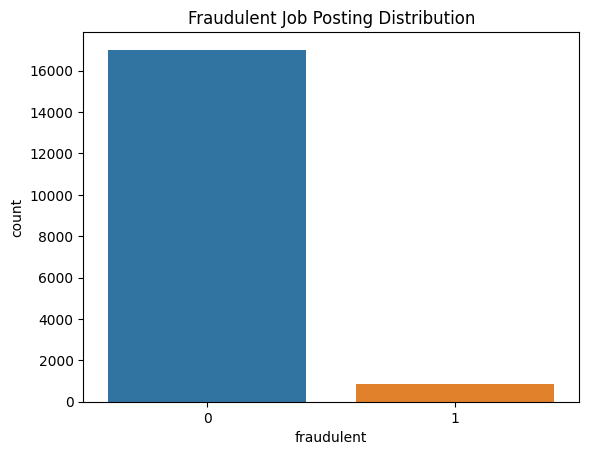

In [9]:
# Veri yapısı ve özelliklerini anlamak için ilk analizler yapılır.
# Bu adımda verinin genel yapısı hakkında bilgi edinilir.

df.info() # Sütun adları, veri tipleri ve eksik veri sayıları hakkında bilgi

df.isnull().sum() # Eksik veri kontrolü

df.nunique() # Her sütunda benzersiz değer sayısı

# Hedef değişken olan 'fraudulent' (sahte ilan mı değil mi) sınıf dağılımını görselleştirelim
sns.countplot(x='fraudulent', data=df)
plt.title('Fraudulent Job Posting Distribution')
plt.show()

In [11]:
# Eksik veriler üzerinde işlemler yapılıyor. 
# İş ilanlarının başlıkları, lokasyonları ve açıklamalarında eksik veriler varsa bunlar silinir.
df.dropna(subset=['title', 'location', 'description'], inplace=True)

# Eksik maaş aralığı ('salary_range') olan satırları 'Not Provided' ile dolduralım.
df['salary_range'].fillna('Not Provided', inplace=True)

In [13]:
# Kategorik değişkenlerin sayısal verilere dönüştürülmesi (Label Encoding).
# Bu işlem, modelin sayısal değerlerle çalışması gerektiği için gereklidir.
label_encoder = LabelEncoder()
df['employment_type'] = label_encoder.fit_transform(df['employment_type'].astype(str))
df['required_experience'] = label_encoder.fit_transform(df['required_experience'].astype(str))
df['required_education'] = label_encoder.fit_transform(df['required_education'].astype(str))

In [14]:
# İş ilanı açıklamalarındaki metin verisini sayısal formata dönüştürmek için TF-IDF (Term Frequency-Inverse Document Frequency) kullanılır.
# Bu, metin verisindeki kelime sıklıklarına dayalı olarak özellik vektörleri oluşturur.
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_text = tfidf.fit_transform(df['description']).toarray()

In [16]:
# Özellikler (bağımsız değişkenler) ve hedef (bağımlı değişken) ayrılır.
# X: Modelin öğrendiği özellikler (iş tanımı metin vektörleri ve diğer kategorik değişkenler)
# y: Hedef değişken (iş ilanının sahte olup olmadığını belirten 'fraudulent' sütunu)
X = np.hstack((X_text, df[['employment_type', 'required_experience', 'required_education']].values))
y = df['fraudulent']

In [17]:
# Veri seti, modelin öğrenmesi için eğitim ve test setlerine ayrılır.
# test_size=0.2, verinin %20'sinin test için ayrılacağını belirtir.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Random Forest sınıflandırıcı modeli oluşturulur ve eğitim seti ile eğitilir.
# Random Forest, farklı karar ağaçları oluşturarak sınıflandırma yapan bir algoritmadır.
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Accuracy: 0.9769033361847733

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3324
           1       0.98      0.57      0.72       183

    accuracy                           0.98      3507
   macro avg       0.98      0.78      0.85      3507
weighted avg       0.98      0.98      0.97      3507



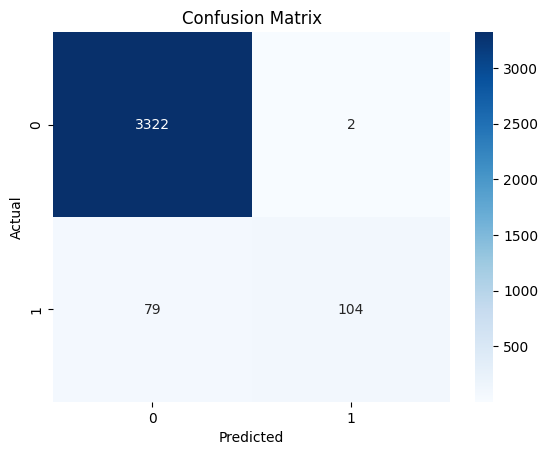

In [21]:
# Test seti üzerindeki tahminler yapılır ve modelin başarımı değerlendirilir.
# accuracy_score: Doğruluk ölçümü
# classification_report: Precision, Recall ve F1-score gibi metrikleri içeren ayrıntılı rapor
y_pred = model.predict(X_test)

# Sonuçları değerlendirelim
print("Accuracy:", accuracy_score(y_test, y_pred)) # Model doğruluk skoru
print("\nClassification Report:\n", classification_report(y_test, y_pred)) # Sınıflandırma raporu

# Confusion matrix: Modelin doğru ve yanlış sınıflandırma performansını gösterir
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()